In [1]:
import matplotlib.pyplot as plt
import importlib.util
import numpy as np
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import skspatial

In [3]:
from skspatial.objects import Circle
from skspatial.objects import Sphere
from skspatial.objects import Line
from skspatial.objects import Point
from skspatial.plotting import plot_2d
from skspatial.plotting import plot_3d
from skspatial.objects import Plane
import random
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

In [4]:
from pyphfit2 import phfit2
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.dataclasses.spectrum import CrashSpectrum as Spec
import scipy.constants as const
import astropy.units as u

In [5]:
def get_simulation_path(halo_id, redshift, conf):
    halo_path = get_sim_path(halo_id=halo_id, redshift=redshift, conf=conf)
    path_out =  os.path.join(halo_path, 'Output/phys_ic00_rt05.out')
    #path_out =  '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn00phys_ic00_rt05.out'
    #path_dens = os.path.join(halo_path, 'Input/dens_ic00.in')
    return path_out#, path_dens

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

In [6]:
def get_sim_path(halo_id, redshift, conf):
    snap = get_snap_num(redshift)
    return f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{halo_id}'

In [7]:
def _get_source_info(ic):
    source_weights = ic.sources['em'].values
    spec = Spec.fromFile(ic.sources['spec_file'].values[0])
    freqs = spec.mids['hnu']/const.h*const.e
    source_packet_shapes = np.empty((len(freqs), len(source_weights)), order='F')
    for i, p in enumerate(ic.sources['spec_file'].values):
        spec = Spec.fromFile(ic.sources['spec_file'].values[i])
        source_packet_shapes[:, i] = spec.getPhotonPacketShape()
    source_pos = np.empty((3, len(source_weights)), order='F')
    for i, key in enumerate(['i', 'j', 'k']):
        source_pos[i, :] = (ic.sources[key]-0.5)
    return freqs, source_weights, source_packet_shapes, source_pos

In [8]:
def get_density_fields(halo_id, redshift, conf):
    sim_path = get_sim_path(halo_id, redshift, conf)

In [9]:
def get_snap_num(redshift):
    redshift_dic = {6:'sn013',8:'sn008',10:'sn004'}
    return redshift_dic[redshift]

In [10]:
def get_sim(halo_id, redshift, conf):
    simpath = get_sim_path(halo_id, redshift, conf)
    return Sim(simpath)

In [11]:
def get_halo_sources_from_sim(sim, ic_num='00'):
    ic = sim.ICs[ic_num]
    luminosities = ic.sources['em'].values
    spec_1 = Spec.fromFile(ic.sources['spec_file'].values[0])
    frequencies = spec_1.mids['hnu']/const.h*const.e
    
    sigma_cm2 = {}
    sigma_cm2['HI'] = np.array(phfit2(1, 1, 1, frequencies*u.Hz).value*1e-18)
    sigma_cm2['HeI'] = np.array(phfit2(2, 2, 1, frequencies*u.Hz).value*1e-18)
    sigma_cm2['HeII'] = np.array(phfit2(2, 1, 1, frequencies*u.Hz).value*1e-18)

    positions = []
    spectra = []
    for i in range(len(luminosities)):
        positions.append([ic.sources['i'][i]-0.5,ic.sources['j'][i]-0.5,ic.sources['k'][i]-0.5])
        
        spec = Spec.fromFile(ic.sources['spec_file'].values[i])
        spectra.append(spec.getPhotonPacketShape())
    return np.array(luminosities), np.array(positions), np.array(spectra), sigma_cm2

In [12]:
def get_halo_sources(halo_id, redshift, conf):
    sim = get_sim(halo_id, redshift, conf)
    lum, pos, spectra, sigma_cm2 = get_halo_sources_from_sim(sim, ic_num='00')
    return lum, pos, spectra, sigma_cm2

In [13]:
def get_density_maps(halo_id, redshift, conf, ic_num='00'):
    path_out = get_simulation_path(halo_id=halo_id, redshift=redshift, conf=conf)
    sim = get_sim(halo_id, redshift, conf)
    ic = sim.ICs[ic_num]
    halo = crashMemMap(path_out, 'all')
    density_maps = {}
    density_maps['HI'] = get_H_map(halo)*ic.getHDensity()
    density_maps['HeI'] = get_He_map(halo)*ic.getHeDensity()
    density_maps['HeII'] = halo[2]*ic.getHeDensity()
    
    cell_size_cm = get_cell_size_cm(ic)
    return cell_size_cm, density_maps

In [14]:
def get_cell_size_cm(ic):
    cell_size = (ic.getCellSize()[1]*u.Mpc).to(u.cm).value
    return cell_size

In [15]:
def get_random_line_2d(source_coordinates):
    phi = np.random.uniform(0,2*np.pi)
    direction = np.array([np.cos(phi), np.sin(phi)])
    line = Line(source_coordinates, direction)
    return line

In [16]:
def get_random_line(source_coordinates):
    theta = np.random.uniform(0,2*np.pi)
    phi = np.arccos(1-2*np.random.uniform(0,1))
    direction = np.array([np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)])
    line = Line(source_coordinates, direction)
    return line

In [17]:
# Return randomly one of the two points where the line crosses 
def get_point_on_sphere(line, sphere):
    s_1, s_2 = sphere.intersect_line(line)
    sphere_point = random.sample([s_1, s_2], 1)[0]
    return sphere_point

In [688]:
def get_crossing_points(source_coordinates, sphere_point, line):
    center_ar = source_coordinates
    sphere_point_ar = np.array(sphere_point)

    epsilon = 1e-13
    
    crossing_points = []
    for i in range(3):
        if center_ar[i]<sphere_point_ar[i]:
            start = center_ar[i]
            end = sphere_point_ar[i]
            increasing = True
        else:
            start = sphere_point_ar[i]
            end = center_ar[i]
            increasing = False

        coordinate = np.ceil(start)
        while coordinate<end:
            if i == 0:
                plane = Plane(point=[coordinate, 0, 0], normal=[1, 0, 0])
                if increasing:
                    correction=[epsilon,0,0]
                else:
                    correction=[-1+epsilon,0,0]
            elif i == 1:
                plane = Plane(point=[0, coordinate, 0], normal=[0, 1, 0])
                if increasing:
                    correction=[0,epsilon,0]
                else:
                    correction=[0,-1+epsilon,0]
            elif i == 2:
                plane = Plane(point=[0, 0, coordinate], normal=[0, 0, 1])
                if increasing:
                    correction=[0,0,epsilon]
                else:
                    correction=[0,0,-1+epsilon]
            else:
                raise ValueError('Dimension has to be 3')
                
            crossing_points.append((np.array(plane.intersect_line(line)), correction))
            coordinate += 1
    return crossing_points

In [689]:
#@jit(nopython=False)
def sort_crossing_points(source_coordinates, crossing_points):
    crossing_tuples = []
    for element in crossing_points:
        crossing_tuples.append((element[0], np.linalg.norm(source_coordinates-element[0]), element[1]))
    sorted_tuples = sorted(crossing_tuples, key=lambda tup: tup[1])
    return sorted_tuples

In [690]:
#@jit(nopython=True)
def cell_coordinates_with_legths(source_coordinates, sphere_point, sorted_crossing_points):        
    coordinate_lengths = []
    start_crossing = source_coordinates
    correction = np.array([0,0,0])
    
    counter=0
    for element in sorted_crossing_points:
        end_crossing = element[0]
        coordinates = np.floor(start_crossing+correction).astype(int)
        crossing_length = np.linalg.norm(end_crossing-start_crossing)
        coordinate_lengths.append((coordinates, crossing_length))
        
        prev = start_crossing
        prev_cor = correction
        start_crossing = end_crossing
        correction = element[2]
    
    coordinates = np.floor(start_crossing+correction).astype(int)
    crossing_length = np.linalg.norm(sphere_point-start_crossing)
    coordinate_lengths.append((coordinates, crossing_length))
    return coordinate_lengths

In [716]:
#@jit(nopython=False)
def get_optical_depth(densities, coordinate_lengths, cross_sections, cell_size):
    individual_depths = []
    density_array = []
    
    optical_depths = np.zeros(len(cross_sections['HI']))
    dens_len = {}
    for key in densities.keys():
        density_length_prod = 0
        for element in coordinate_lengths:
            dens = densities[key][element[0][0], element[0][1], element[0][2]]
            density_array.append(dens)
            density_length_prod += dens*element[1]
        dens_len[key] = density_length_prod
        optical_depths += density_length_prod*cell_size*cross_sections[key]
        #individual_depths.append(density_length_prod*cell_size*cross_sections[key])
    return optical_depths, dens_len#, np.array(individual_depths), np.array(density_array)

In [22]:
#@jit(nopython=False)
def get_line_esc(emitted, optical_depths):
    return emitted*np.exp(-1*optical_depths)

In [23]:
#@jit(nopython=False)
def batch_esc(sphere, source_pos, densities, emitted, cell_size, ray_number, cross_sections):
    escaped = np.zeros(len(cross_sections['HI']))
    dens_len_dict = {}
    for key in densities.keys():
        dens_len_dict[key] = []
    for i in range(ray_number):
        line = get_random_line(source_coordinates=source_pos)
        sphere_point = get_point_on_sphere(line=line, sphere=sphere)
        crossing_points = get_crossing_points(source_coordinates=source_pos, 
                                              sphere_point=sphere_point, line=line)
        sorted_crossing_points = sort_crossing_points(source_coordinates=source_pos, 
                                                      crossing_points=crossing_points)
        coord_lengths = cell_coordinates_with_legths(source_coordinates=source_pos, 
                                                    sphere_point=sphere_point, 
                                                    sorted_crossing_points=sorted_crossing_points)
        optical_depths, dens_len = get_optical_depth(densities=densities, 
                                           coordinate_lengths=coord_lengths, 
                                           cross_sections=cross_sections, 
                                           cell_size=cell_size)
        new_escaped = get_line_esc(emitted=emitted, optical_depths=optical_depths) 
        
        for key in dens_len_dict.keys():
            dens_len_dict[key].append(dens_len[key])
        #print(new_escaped)
        escaped += new_escaped
    return escaped/ray_number, dens_len_dict

In [24]:
#@jit(nopython=False)
def calculate_source_esc(densities, source_pos, cross_sections, luminosity, 
                         spectrum, cell_size, halo_radius, halo_center, 
                        ray_number=100, threshold=0.01):

    sphere = Sphere(halo_center, halo_radius)
    emitted = luminosity*spectrum
    escaped, dens_len_dict = batch_esc(sphere=sphere, source_pos=source_pos, 
                        densities=densities, emitted=emitted, cell_size=cell_size, 
                        ray_number=ray_number, cross_sections=cross_sections)
    current_esc = escaped
    current_fesc = np.sum(escaped)/np.sum(emitted)
    counter = 1
    while True:
        new_escaped, _ = batch_esc(sphere=sphere, source_pos=source_pos, 
                        densities=densities, emitted=emitted, cell_size=cell_size, 
                        ray_number=ray_number, cross_sections=cross_sections)
        updated_fesc = (counter*current_fesc+np.sum(new_escaped)/np.sum(emitted))/(counter+1)
        updated_esc = (counter*current_esc+new_escaped)/(counter+1)
        if np.abs((updated_fesc-current_fesc)/current_fesc)<threshold:
            break
        current_fesc = updated_fesc
        current_esc = updated_esc
        counter += 1
        if counter>5:
            break
    return updated_fesc, updated_esc, dens_len_dict

In [25]:
# Testing function to obtain the escape fraction by tracing a single line between two points
#@jit(nopython=False)
def two_point_escape(origin_coord, end_coord, densities, emitted, cell_size, cross_sections):
    origin = Point(origin_coord)
    end = Point(end_coord)
    line = Line(origin_coord, np.array(end_coord)-np.array(origin_coord))

    crossing_points = get_crossing_points(source_coordinates=origin, 
                                          sphere_point=end, line=line)
    sorted_crossing_points = sort_crossing_points(source_coordinates=origin, 
                                                  crossing_points=crossing_points)
    coord_lengths = cell_coordinates_with_legths(source_coordinates=origin, 
                                                sphere_point=end, 
                                                sorted_crossing_points=sorted_crossing_points)
    optical_depths, individual_depths, density_array = get_optical_depth(densities=densities, 
                                       coordinate_lengths=coord_lengths, 
                                       cross_sections=cross_sections, 
                                       cell_size=cell_size)
    escaped = get_line_esc(emitted=emitted, optical_depths=optical_depths) 
    fesc = np.sum(escaped)/np.sum(emitted)
    return fesc, escaped

In [ ]:
# Test 1: f_esc=0.1
cell_size = 1
dens = {'HI':-np.log(0.1)/50*np.ones((101,101,101))}
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = 1
cross_section =  {'HI':np.array([1])}

f_esc, per_freq, _ = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center)
print(per_freq)
print(f_esc)

In [ ]:
# Test 2: per_freq=[0.1, 0.005, 0.002] f_esc=0.030571428571428576 (several values in the spectrum and the crossection)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5, 2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=100, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 3: approximately per_freq_esc=[0.25, 0.0625, 0.125] f_esc=0.125 (one half opaque)
cell_size = 1
sigma = 1
dens = -np.log(0.5)/50*np.ones((101,101,101))
dens[51:, :, :] = 1
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5 ,2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=1000, threshold=0.001)
print(f_esc)
print(per_freq)

In [ ]:
# Test 4: approximately per_freq=[0.3625] f_esc=0.3625 (4 different densities)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[51:, 51:, :] = -np.log(0.25)/50
dens[:51, 51:, :] = -np.log(0.4)/50
dens[:51, :51, :] = -np.log(0.7)/50
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1])
cross_section = np.array([1])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=1000, threshold=0.001)
print(f_esc)
print(per_freq)

In [ ]:
# Test 5: approximately per_freq=[0.6844607732186937] f_esc=0.6844607732186937 (4 different densities)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[51:, 51:, :] = -np.log(0.25)/50
dens[:51, 51:, :] = -np.log(0.4)/50
dens[:51, :51, :] = -np.log(0.7)/50
r_halo = 50
luminosity = 1
spectrum = np.array([1])
cross_section = np.array([1])

source_pos_1 = [45.5, 55.5, 30.5]  
end_pos_1 = [5.5, 90.5, 30.5]
line_1 = Line(source_pos_1, np.array(end_pos_1)-np.array(source_pos_1))
f_esc_1, per_freq_1 = two_point_escape(origin_coord=source_pos_1, end_coord=end_pos_1, 
                                   densities=dens, emitted=emitted, cell_size=cell_size, 
                                   cross_sections=cross_section)
print(f_esc_1)
print(per_freq_1)

source_pos_2 = [60, 20, 30]  
end_pos_2 = [63, 80, 30]
line_2 = Line(source_pos_2, np.array(end_pos_2)-np.array(source_pos_2))
f_esc_2, per_freq_2 = two_point_escape(origin_coord=source_pos_2, end_coord=end_pos_2, 
                                   densities=dens, emitted=emitted, cell_size=cell_size, 
                                   cross_sections=cross_section)
print(f_esc_2)
print(per_freq_2)

In [ ]:
# Test 6: f_esc=0.001
cell_size = 1
dens = {}
dens['HI'] = -np.log(0.1)/50*np.ones((101,101,101))
dens['HeI'] = -np.log(0.1)/50*np.ones((101,101,101))
dens['HeII'] = -np.log(0.1)/50*np.ones((101,101,101))
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = 1
cross_sections = {'HI':np.array([1]), 'HeI':np.array([1]), 'HeII':np.array([1])}
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_sections, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=cell_size, halo_radius=r_halo, halo_center=halo_center)
print(per_freq)
print(f_esc)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e5')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e5')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e5 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, '524_1029')
cell_size_cm, densities =  get_density_maps(1029, 8, '524_1029')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, '524__1e5')
cell_size_cm, densities =  get_density_maps(1029, 8, '524__1e5')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e5 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'full_esc')
cell_size_cm, densities =  get_density_maps(1029, 8, 'full_esc')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e7 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e8')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e8')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e8 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [ ]:
tick_label_size=30
labelsize=50
x_label = r'$\log \left( \sum_i \frac{l_i}{l_\mathrm{cell}} \rho_i \right)$'
y_label = 'counts'
values_1e5 = np.log10(dens_len_dict_1e5['HI'])
values_1e6 = np.log10(dens_len_dict_1e6['HI'])
values_1e7 = np.log10(dens_len_dict_1e7['HI'])
values_1e8 = np.log10(dens_len_dict_1e8['HI'])
data = np.zeros((len(values_1e5), 4))
data[:,0] = values_1e5
data[:,1] = values_1e6
data[:,2] = values_1e7
data[:,3] = values_1e8
labels = ['$10^5$', '$10^6$', '$10^7$', '$10^8$']
bins = np.linspace(data.min(),data.max(), 10)
plt.hist(data, bins=bins, width = 0.12, label=labels)
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);

In [26]:
def get_density_maps_mod(halo_id, redshift, conf, ic_num='00'):
    path_out = get_simulation_path(halo_id=halo_id, redshift=redshift, conf=conf)
    sim = get_sim(halo_id, redshift, conf)
    ic = sim.ICs[ic_num]
    
    halo = crashMemMap(path_out, 'all')
    density_maps = {}
    
    HI_map = get_H_map(halo)
    HeI_map = get_He_map(halo)
    HeII_map = np.zeros_like(halo[2])+halo[2]
    
#     HI_map[HI_map<1e-2] = 0.
#     HeI_map[HeI_map<1e-2] = 0.
#     HeII_map[HeII_map<1e-2] = 0.
    
    density_maps['HI'] = HI_map*ic.getHDensity()
    density_maps['HeI'] = HeI_map*ic.getHeDensity()
    density_maps['HeII'] = HeII_map*ic.getHeDensity()
    
    cell_size_cm = get_cell_size_cm(ic)
    return cell_size_cm, density_maps

In [ ]:
confs = ['single_source_1e5','single_source_1e6','single_source_1e7','single_source_1e8']
keys = ['1e5', '1e6', '1e7', '1e8']
dens_len_dict = {}
densities = {}
for i in range(4):
    np.random.seed(42)
    random.seed(42)
    lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, confs[i])
    cell_size_cm, densities[keys[i]] =  get_density_maps_mod(1029, 8, confs[i])
    radius = densities[keys[i]]['HI'].shape[0]/2
    halo_center = [radius, radius, radius]
    f_esc, per_freq, dens_len_dict[keys[i]] = calculate_source_esc(densities=densities[keys[i]], source_pos=pos[0], cross_sections=sigma_cm2, 
                                 luminosity=lum[0], spectrum=spectra[0], 
                                 cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                                ray_number=1000, threshold=0.1)
    print(f_esc)
#print(per_freq)

In [ ]:
tick_label_size=30
labelsize=50
x_label = r'$\log(\rho_{HI})$'
y_label = 'counts'
values_1e5 = densities['1e5']['HI'].flatten()+1e-10
values_1e6 = densities['1e6']['HI'].flatten()+1e-10
values_1e7 = densities['1e7']['HI'].flatten()+1e-10
values_1e8 = densities['1e8']['HI'].flatten()+1e-10
data = np.zeros((len(values_1e5), 4))
data[:,0] = values_1e5/values_1e8
data[:,1] = values_1e6/values_1e8
data[:,2] = values_1e7/values_1e8
labels = ['$10^5$', '$10^6$', '$10^7$']
bins = np.linspace(data.mean()-3*data.std(),data.mean()+3*data.std(), 10)
print(data.min())
print(data.max())
print(data.std())
plt.hist(data, bins=bins, label=labels)
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);

In [ ]:
conf = 'stroemgren_1e7'
path_out = get_simulation_path(halo_id=1029, redshift=8, conf=conf)
sim = get_sim(halo_id=1029, redshift=8, conf=conf)
ic = sim.ICs['00']

halo = crashMemMap(path_out, 'all')
density_maps = {}

cell_size_cm = get_cell_size_cm(ic)

In [ ]:
test_path = f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e8/run/L35n2160TNG/sn008/g1029'
test = Sim(test_path)

In [ ]:
ic.info['boxdimension']['cMpc']*3.086e+24

In [ ]:
def stroemgren_rad_from_ion(boxsize, ionfrac):
    return (3*(boxsize)**3*ionfrac/(4*np.pi))**(1/3)

In [ ]:
def stroemgren_rad(density, temperature, luminosity):
    beta =2.6e-13
    radius = (3/(4*np.pi)*luminosity/(density**2*beta))**(1/3)
    return radius

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
f, ax = plt.subplots(1, 1)
ax.imshow(dens[:, :, 30], extent=[0, 101, 0, 101])
x = np.arange(5,41)
ax.plot(x, 95-x, '--', linewidth=4, color='green', label='line 1: dens=0.007133')
x_new = np.arange(1,5)
ax.plot(x_new+59, x_new*20, '--', linewidth=4, color='white',  label='line 2: dens=0.0277, 0.01833')
ax.scatter(61.55, 50, color='white')
plt.legend(fontsize=25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

Line 1: Origin (45, 55, 30)  End (5, 90, 30) l=53.1507 <br>
Line 2: Origin (60, 20, 30)  End (63, 80, 30) Crossing (61.55, 51, 30)

In [ ]:
import numba

In [ ]:
# Test 3: per_freq=[0.05, 0.0024, 0.001] f_esc=0.015285714285714288
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[50:, :, :] = 1
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5, 2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=100, threshold=0.0001)
print(f_esc)
print(per_freq)

# Working at healpix maps

In [28]:
import healpy as hp

In [56]:
import scipy

In [325]:
theta = np.linspace(0, 2*np.pi, 36)
phi = np.linspace(0, np.pi, 18)
Lon,Lat = np.meshgrid(theta, phi)
spherical = scipy.special.sph_harm(-4, 4, Lon, Lat)

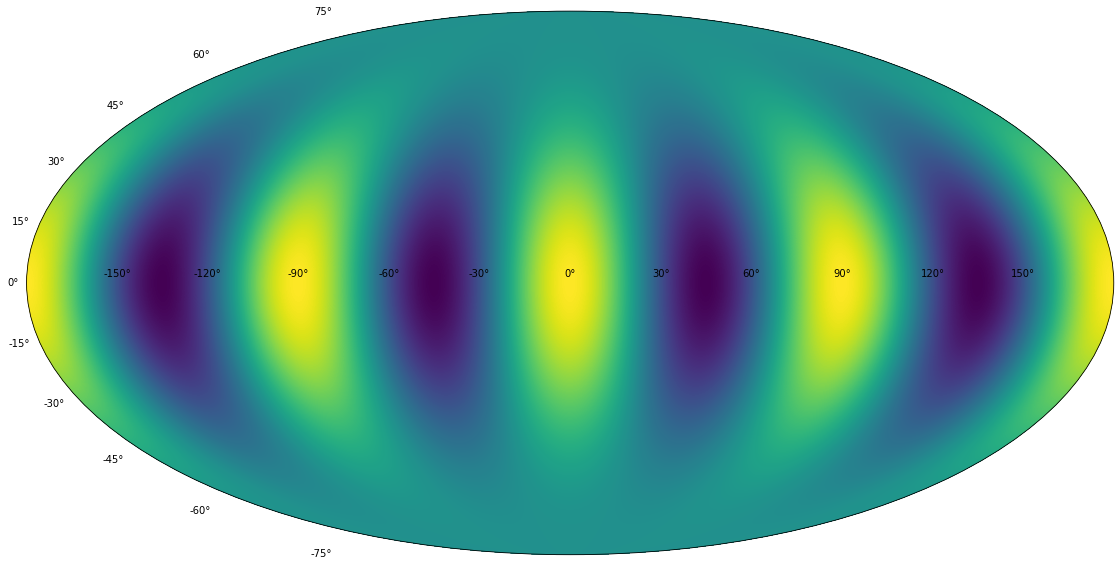

In [321]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

# lon = np.linspace(-np.pi, np.pi,360)
# lat = np.linspace(-np.pi/2., np.pi/2.,180)
# Lon,Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, np.real(spherical))#, cmap=plt.cm.jet)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [177]:
def center_point(dens_map):
    return np.array(dens_map.shape)/2

In [806]:
def average_dens(phi, theta, densities, cell_size):
    halo_center = np.array(center_point(densities['HI']))
    radius =  densities['HI'].shape[0]/2
    sphere = Sphere(halo_center, radius)
    direct = direction(phi, theta)
    average_dens_dict = {}
    cross_sections = {}
    for key in densities.keys():
        cross_sections[key] = np.ones(2)
    
    line = Line(halo_center, direct)
    sphere_point = get_direct_point_on_sphere(sphere, direct, line, halo_center)
    crossing_points = get_crossing_points(source_coordinates=halo_center, 
                                          sphere_point=sphere_point, line=line)
    sorted_crossing_points = sort_crossing_points(source_coordinates=halo_center, 
                                                  crossing_points=crossing_points)
    coord_lengths = cell_coordinates_with_legths(source_coordinates=halo_center, 
                                                sphere_point=sphere_point, 
                                                sorted_crossing_points=sorted_crossing_points)
    optical_depths, dens_len_dict = get_optical_depth(densities=densities, 
                                       coordinate_lengths=coord_lengths, 
                                       cross_sections=cross_sections, 
                                       cell_size=cell_size)

    for key in dens_len_dict.keys():
        averaged_dens = np.sum(dens_len_dict[key])/radius
        average_dens_dict[key] = averaged_dens
    #print(average_dens_dict['HI'])
    return average_dens_dict['HI']

In [423]:
def direction(phi, theta):
    x = np.sin(phi)*np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(phi)
    return np.array([x,y,z])

In [424]:
def get_direct_point_on_sphere(sphere, direct, line, center):
    s_1, s_2 = sphere.intersect_line(line)
    if np.all((np.array(s_1) >= center) == (direct >= 0)):
        sphere_point = s_1
    else:
        sphere_point = s_2
    return sphere_point

In [742]:
def density_map(phi_arr, theta_arr, densities, cell_size, save=False, name=None, path='/u/ivkos/analysis/plots/maps'):
    density_map = []
    for phi in phi_arr:
        sub_dens = []
        for theta in theta_arr:
            sub_dens.append(average_dens(phi, theta, densities, cell_size))
        #print(sub_dens)
        density_map.append(sub_dens)
    if save:
        save_path = os.path.join(path, name+'_' + str(len(phi_arr)))
        np.save(save_path, np.array(density_map))
    return density_map

In [723]:
def los_esc(phi, theta, densities, cell_size, cross_sections, source_pos, spectrum):
    halo_center = np.array(center_point(densities['HI']))
    radius =  densities['HI'].shape[0]/2
    sphere = Sphere(halo_center, radius)
    direct = direction(phi, theta)
    
    line = Line(halo_center, direct)
    sphere_point = get_direct_point_on_sphere(sphere, direct, line, halo_center)
    line_source_sphere = line.from_points(source_pos, sphere_point)
    crossing_points = get_crossing_points(source_coordinates=source_pos, 
                                          sphere_point=sphere_point, line=line_source_sphere)
    sorted_crossing_points = sort_crossing_points(source_coordinates=source_pos, 
                                                  crossing_points=crossing_points)
    coord_lengths = cell_coordinates_with_legths(source_coordinates=source_pos, 
                                                sphere_point=sphere_point, 
                                                sorted_crossing_points=sorted_crossing_points)
    optical_depths, dens_len_dict = get_optical_depth(densities=densities, 
                                       coordinate_lengths=coord_lengths, 
                                       cross_sections=cross_sections, 
                                       cell_size=cell_size)
    escape_frac = np.sum(np.exp(-1*optical_depths)*spectrum)/np.sum(spectrum)
    return escape_frac

In [683]:
def calculate_source_esc_map(densities, source_pos, cross_sections,
                        cell_size, phi_arr, theta_arr, spectrum):
    escape_map = []
    for phi in phi_arr:
        sub_esc = []
        for theta in theta_arr:
            esc = los_esc(phi, theta, densities, cell_size, cross_sections, source_pos, spectrum)
            sub_esc.append(esc)
        escape_map.append(sub_esc)
    #save_path = os.path.join(path, name+'_' + str(len(phi_arr)))
    #np.save(save_path, np.array(density_map))
    return escape_map

In [785]:
def calculate_full_esc_map(densities, sources, cross_sections, cell_size, phi_arr, theta_arr, 
                           spectra, luminosities, save=False, name=None, path='/u/ivkos/analysis/plots/maps'):
    
    map_sum = np.zeros([len(phi_arr), len(theta_arr)])
    for i, pos in enumerate(sources):
        new_map = calculate_source_esc_map(densities, pos, cross_sections, cell_size, phi_arr, theta_arr, spectra[i])
        map_sum += np.array(new_map)*luminosities[i]
    escape_map = map_sum/np.sum(luminosities)
    if save:
        save_path = os.path.join(path, name+'_' + 'esc_' + str(len(phi_arr)))
        np.save(save_path, escape_map)
    return escape_map

In [870]:
halo_num = 1544#2989

In [865]:
path_out = get_simulation_path(halo_id=halo_num, redshift=8, conf='new_main')
sim = get_sim(halo_id=halo_num, redshift=8, conf='new_main')
ic = sim.ICs['00']
halo = crashMemMap(path_out, 'all')
density_maps = {}
density_maps['HI'] = get_H_map(halo)
density_maps['HeI'] = get_He_map(halo)
density_maps['HeII'] = halo[2]

In [871]:
size, dens = get_density_maps_mod(halo_id=halo_num, redshift=8, conf='new_main', ic_num='00')

In [872]:
lum, pos, spectra, sigma_cm2 = get_halo_sources(halo_id=halo_num, redshift=8, conf='new_main')

In [874]:
theta = np.linspace(0, 2*np.pi, 360)
phi = np.linspace(0, np.pi, 180)

avg_densities = density_map(phi, theta, densities=dens, cell_size=size, save=True, name=f'{halo_num}')

In [846]:
import time

In [847]:
start = time.time()
avg_esc = calculate_full_esc_map(densities=dens, sources=pos, cross_sections=sigma_cm2,
                            cell_size=size, phi_arr=phi, theta_arr=theta, spectra=spectra, luminosities=lum, save=True, name=f'{halo_num}_test')
print(f'Total time needed: {time.time()-start}')

Total time needed: 16411.48062157631


In [875]:
!ls /u/ivkos/analysis/plots/maps

1544_180.npy	       1544_test_ion.npy  2989_test_esc_180.npy
1544_test_18.npy       2989_ion_180.npy   2989_test_esc_18.npy
1544_test_esc_180.npy  2989_test_180.npy
1544_test_esc_18.npy   2989_test_18.npy


In [889]:
low_esc_dens = np.load('/u/ivkos/analysis/plots/maps/1544_180.npy')
low_esc_esc = np.load('/u/ivkos/analysis/plots/maps/1544_test_esc_180.npy')
low_esc_ion = np.load('/u/ivkos/analysis/plots/maps/1544_test_ion.npy')

high_esc_dens = np.load('/u/ivkos/analysis/plots/maps/2989_test_180.npy')
high_esc_esc = np.load('/u/ivkos/analysis/plots/maps/2989_test_esc_180.npy')
high_esc_ion = np.load('/u/ivkos/analysis/plots/maps/2989_ion_180.npy')

In [905]:
import matplotlib.ticker as ticker

In [919]:
base = '/u/ivkos/analysis/plots'

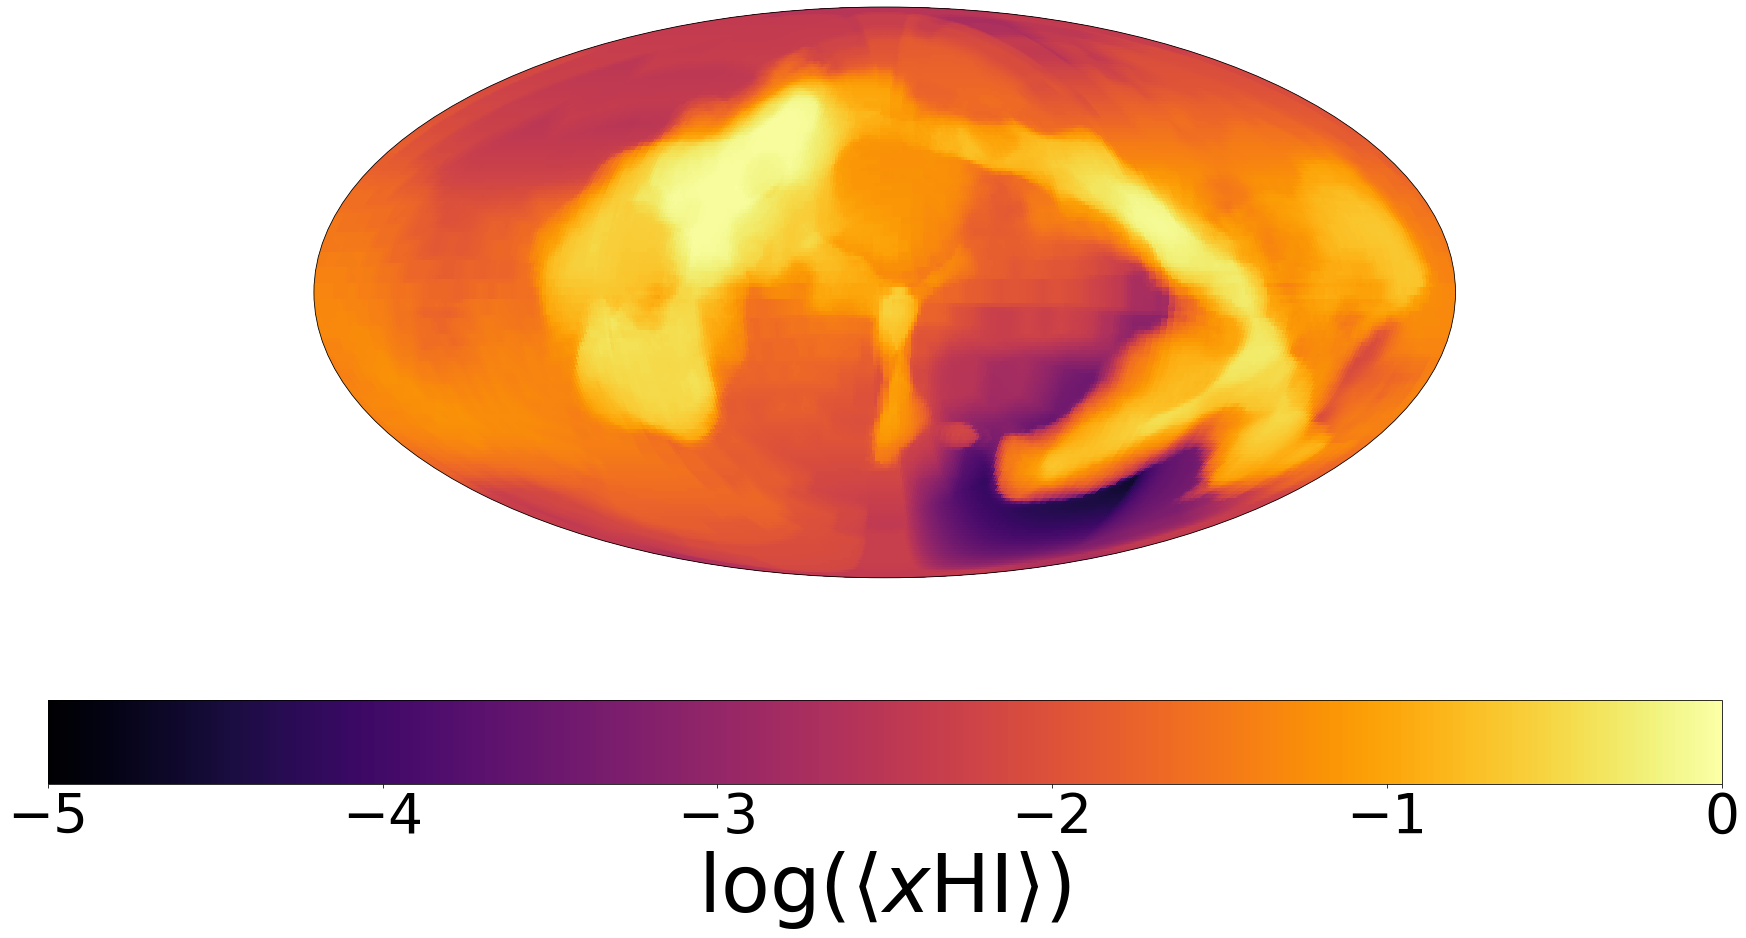

In [935]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, np.log(low_esc_ion), cmap=plt.get_cmap('inferno'), vmin = -5.0, vmax= 0.0)
#cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, orientation='horizontal')#,cax=cax)
cbar.set_label(r'log($\langle x\mathrm{HI} \rangle$)', size=80)
#cbar.ax.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (30, 15)

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
#plt.title('Average HI density', size=50)
plt.rcParams['axes.titlepad'] = 45
cbar.ax.tick_params(labelsize=55)
savepath = os.path.join(base, 'low_esc_ion.png')
plt.savefig(savepath, bbox_inches='tight')
plt.show()

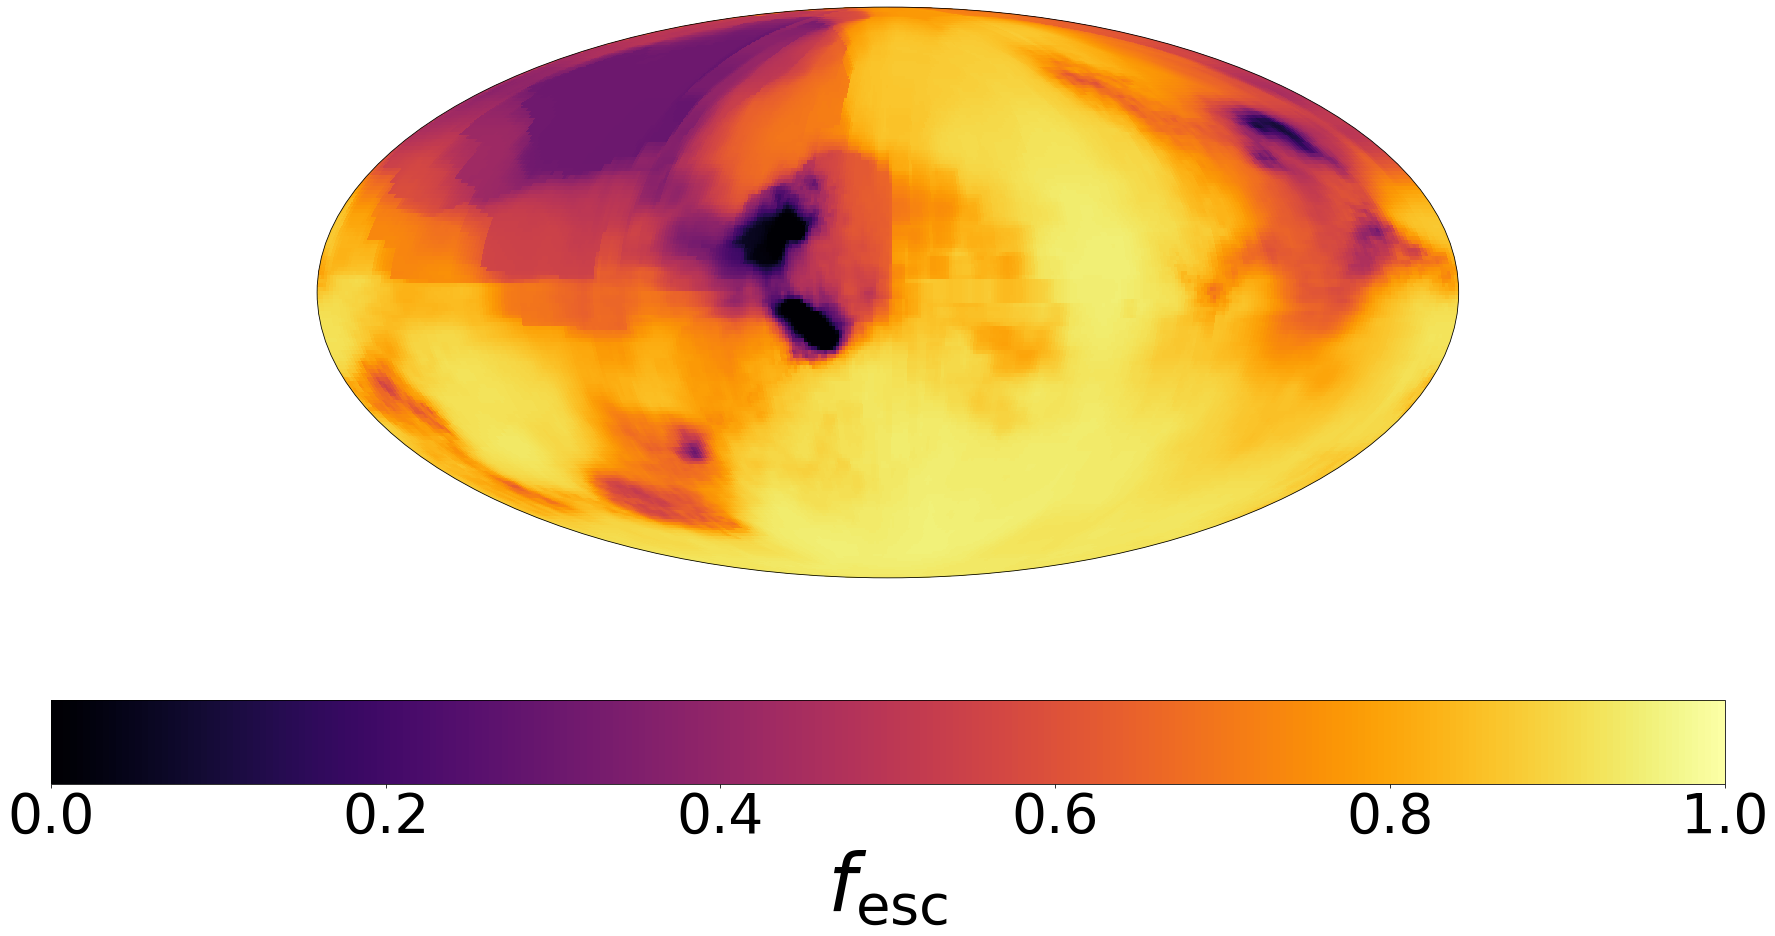

In [937]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, high_esc_esc, cmap=plt.get_cmap('inferno'), vmin = 0, vmax= 1.0)
#cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, orientation='horizontal')#,cax=cax)
cbar.set_label(r'$f_\mathrm{esc}$', size=80)
#cbar.ax.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (30, 15)

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
#plt.title('Average HI density', size=50)
plt.rcParams['axes.titlepad'] = 45
cbar.ax.tick_params(labelsize=55)
savepath = os.path.join(base, 'high_esc_esc.png')
plt.savefig(savepath, bbox_inches='tight')
plt.show()

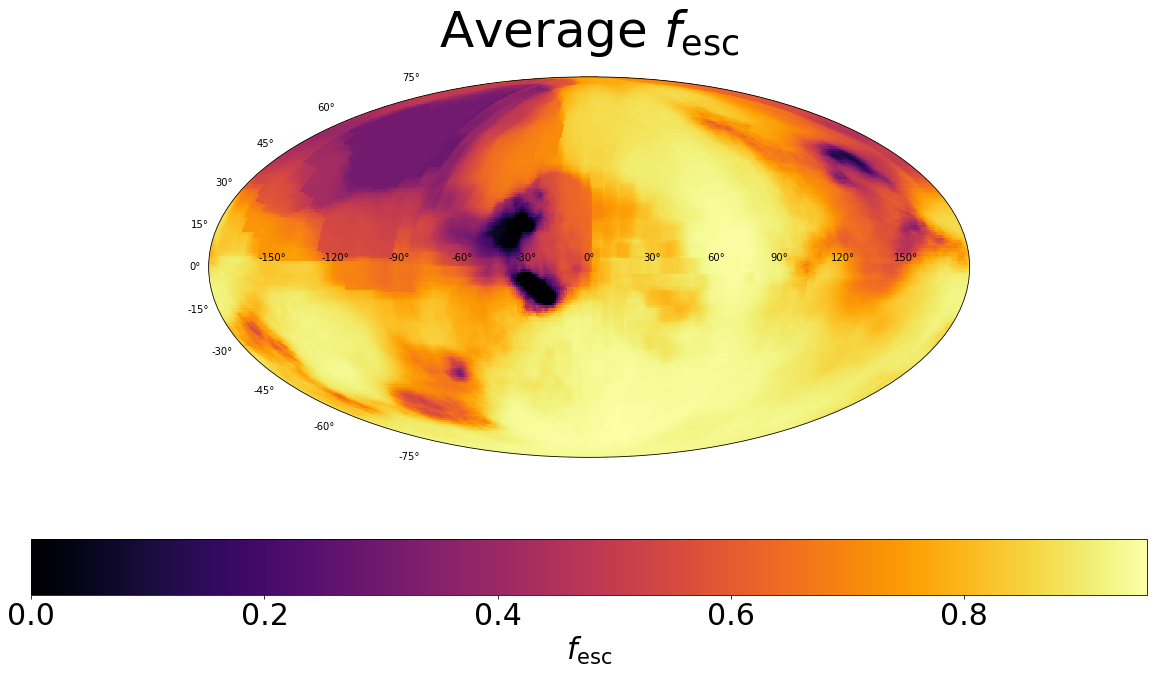

In [884]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, high_esc_esc, cmap=plt.get_cmap('inferno'))
#cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, orientation='horizontal')
cbar.set_label(r'$f_\mathrm{esc}$', size=30)
#cbar.ax.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title(r'Average $f_\mathrm{esc}$', size=50)
plt.rcParams['axes.titlepad'] = 30
cbar.ax.tick_params(labelsize=30)
plt.show();

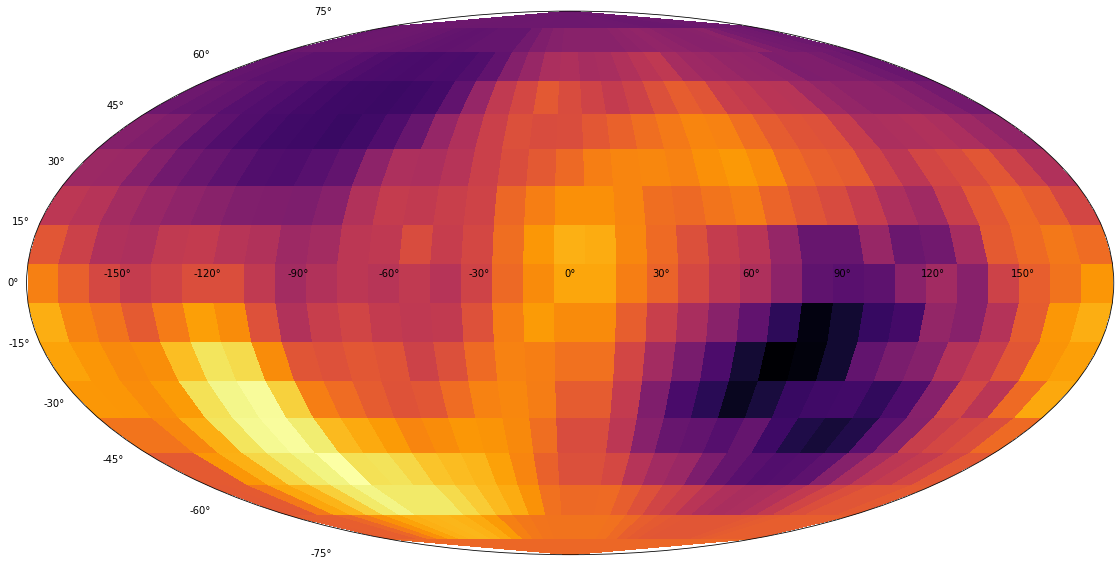

In [509]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, np.log(avg_densities).T, cmap=plt.get_cmap('inferno'))
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [442]:
import cartopy.crs as ccrs

TypeError: Dimensions of C (18, 36) are incompatible with X (360) and/or Y (180); see help(pcolormesh)

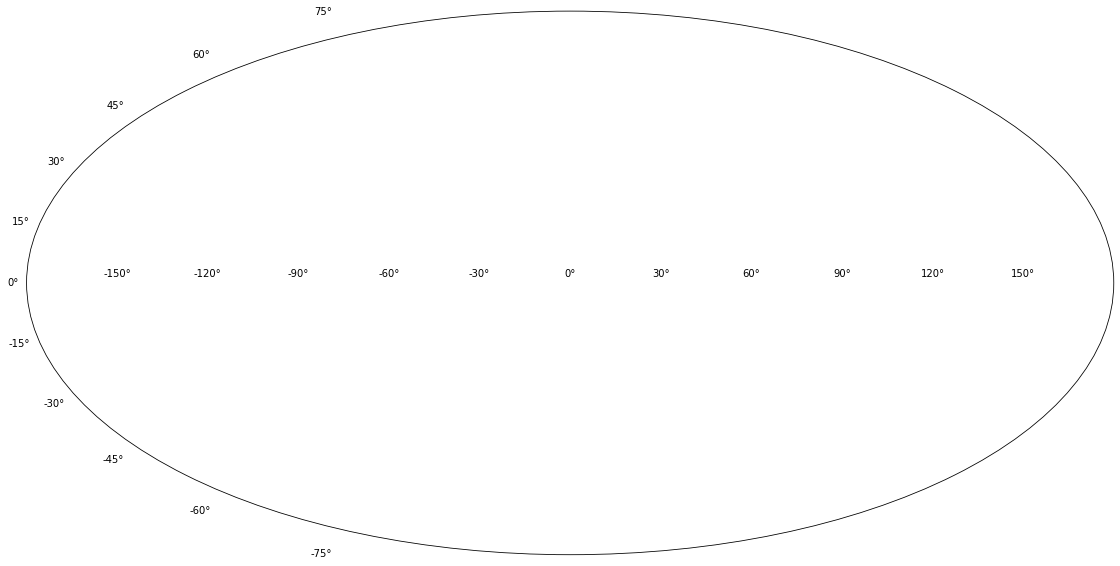

In [502]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, np.log(avg_densities), cmap=plt.get_cmap('inferno'))
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

TypeError: Dimensions of C (36, 18) are incompatible with X (36) and/or Y (18); see help(pcolormesh)

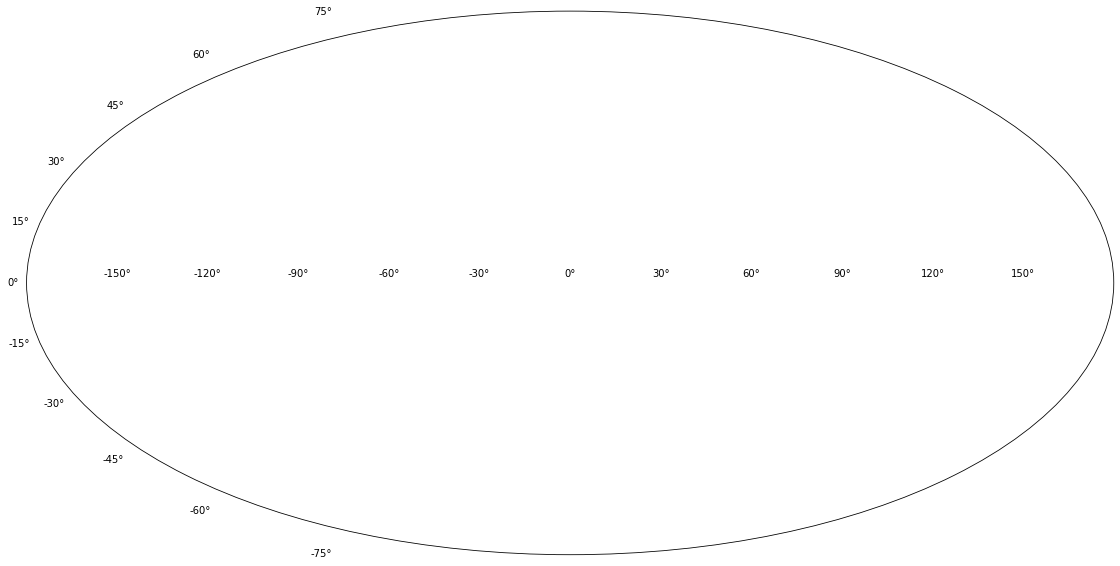

In [513]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im2 = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, avg_densities, cmap=plt.get_cmap('inferno'))
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

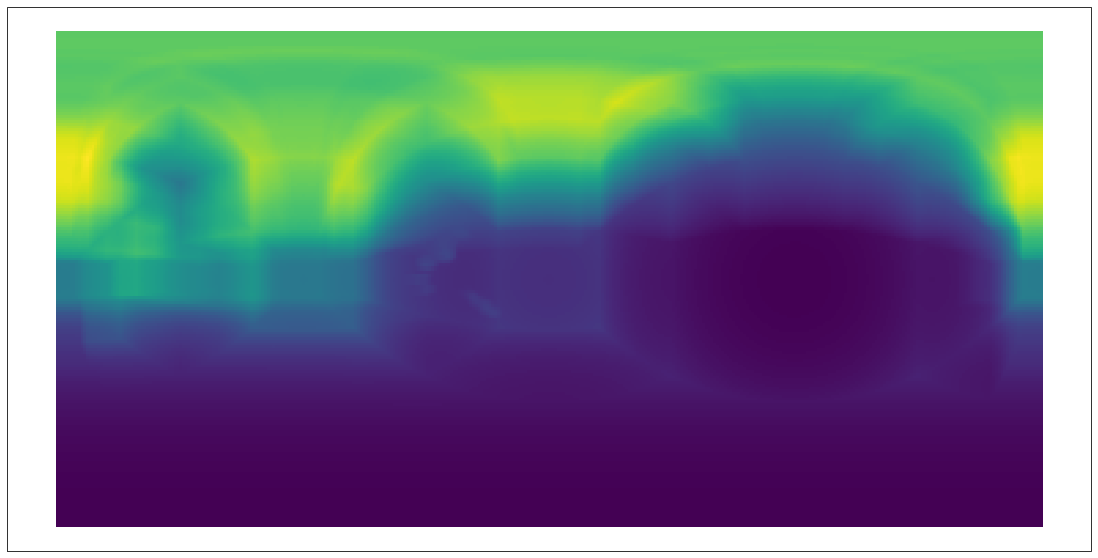

In [471]:
#fig = plt.figure()
ax = plt.axes(projection=ccrs.Mollweide())
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh((Lon - np.pi)*180/np.pi ,(Lat - np.pi/2)*180/np.pi, avg_densities, transform=ccrs.Mollweide())#plt.get_cmap('inferno'))
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
#plt.colorbar(im, orientation='horizontal',cax=cax)
#cbar.ax.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [350]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

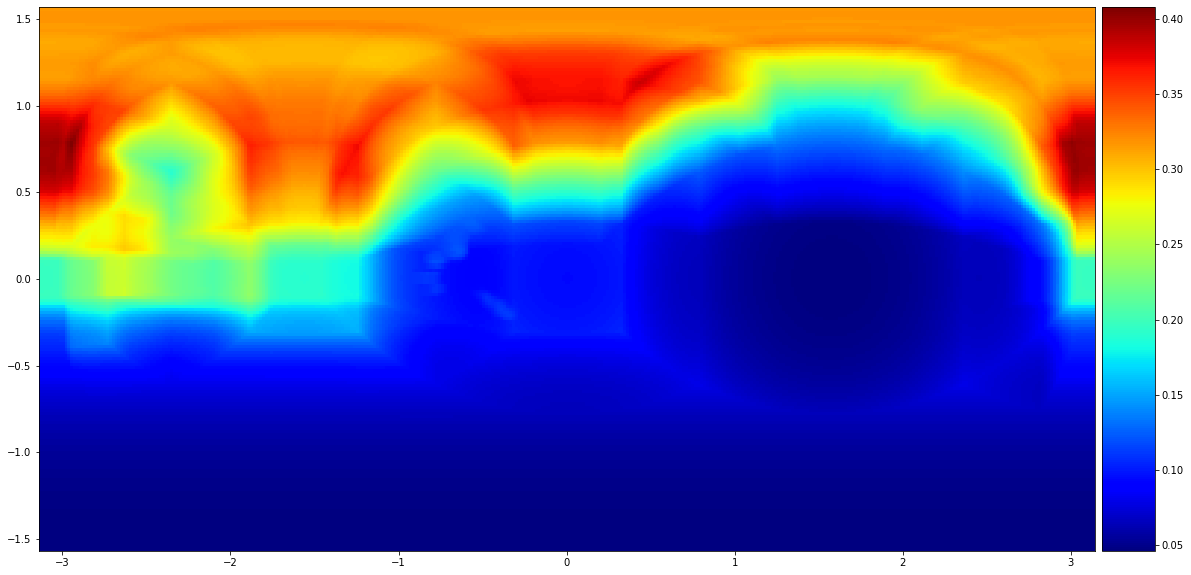

In [494]:
fig = plt.figure()
ax = fig.add_subplot(111)
Lon,Lat = np.meshgrid(theta, phi)
im = ax.pcolormesh(Lon - np.pi ,Lat - np.pi/2, avg_densities, cmap=plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [357]:
avg_densities

[[0.04618919059654474,
  0.04618919059654474,
  0.317188075331414,
  0.04618919059654474,
  0.04618919059654474,
  0.04618919059654474,
  0.317188075331414,
  0.317188075331414,
  0.317188075331414,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.04618919059654474,
  0.04618919059654474,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.04618919059654474,
  0.317188075331414,
  0.317188075331414,
  0.04618919059654474,
  0.04618919059654474,
  0.04618919059654474,
  0.04618919059654474,
  0.04618919059654474,
  0.04618919059654474,
  0.317188075331414,
  0.317188075331414],
 [0.04699106646099513,
  0.3251008423611097,
  0.04699112776896376,
  0.04699086619620538,
  0.31138472999264405,
  0.0469909417349262,
  0.3187830714607216,
  0.04699254142456002,
  0.04699557822392792,
 

In [194]:
directions.shape

(3, 180, 360)

In [196]:
np.sum(np.square(directions), axis=0)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [178]:
print(center_point(dens['HI']))

[58.5 58.5 58.5]


In [173]:
dens['HI'].shape

(117, 117, 117)

# Stopped working on healpix maps

In [ ]:
import time

In [ ]:
start_time = time.time()
source_coordinates = [200.5, 200.5, 400.5]
sphere_center = [500,500,500]
test_sphere = Sphere(sphere_center, 500)

for j in range(1000):
    test_line = get_random_line(source_coordinates)
    sphere_point = get_point_on_sphere(test_line, test_sphere)
    crossing_points = get_crossing_points(source_coordinates, sphere_point, test_line)
    sorted_crossing_points = sort_crossing_points(source_coordinates, crossing_points)
    coord_length = cell_coordinates_with_legths(source_coordinates, sphere_point, sorted_crossing_points)
print(time.time()-start_time())

In [ ]:
source_coordinates = [20.5, 20.5, 30.5]
sphere_center = [50,50,50]
test_sphere = Sphere(sphere_center, 50)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test_sphere.plot_3d(ax, alpha=0.2)
for i in range(100):
    test_line = get_random_line(source_coordinates)
    sphere_point = get_point_on_sphere(test_line, test_sphere)
    crossing_points = get_crossing_points(source_coordinates, sphere_point, test_line)
    sorted_crossing_points = sort_crossing_points(source_coordinates, crossing_points)

    test_line.plot_3d(ax, t_1=-9, t_2=9, c='k')
    point = Point(source_coordinates)
    point.plot_3d(ax, c='r')
    sphere_point.plot_3d(ax, c='b')
    for element in sorted_crossing_points:
        point = Point(element[0])
        point.plot_3d(ax, c='g')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test_sphere.plot_3d(ax, alpha=0.2)

test_test = Sphere([5,5,5], 5)
test_test.plot_3d(ax, alpha=0.1)
test_line.plot_3d(ax, t_1=-5, t_2=10, c='k')
point = Point(source_coordinates)
point.plot_3d(ax, c='r')
sphere_point.plot_3d(ax, c='b')
for element in sorted_crossing_points:
    point = Point(element[0])
    point.plot_3d(ax, c='g')

In [ ]:
sphere = Sphere([0,0,0], 3)
direction_3d = np.array([np.sin(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.cos(theta)])
line_3d = Line(center_3d, center_3d+direction_3d)

center_ar = np.array(center_3d)
sphere_point_ar = np.array(sphere_point)
#np.floor(np.array(end_point))
crossing_points = []
for i in range(3):
    if center_ar[i]<sphere_point_ar[i]:
        start = center_ar[i]
        end = sphere_point_ar[i]
    else:
        start = sphere_point_ar[i]
        end = center_ar[i]
        
    coordinate = np.ceil(start)
    while coordinate<end:
        if i == 0:
            plane = Plane(point=[coordinate, 0, 0], normal=[1, 0, 0])
        elif i == 1:
            plane = Plane(point=[0, coordinate, 0], normal=[0, 1, 0])
        elif i == 2:
            plane = Plane(point=[0, 0, coordinate], normal=[0, 0, 1])
        else:
            raise ValueError('Dimension has to be 3')
        crossing_points.append(plane.intersect_line(line_3d))
        coordinate += 1

In [ ]:
crossing_points

In [ ]:
np.array(sphere_point)

In [ ]:
center_ar[0]
sphere_point_ar[0]

In [ ]:
_, ax = plot_2d(
    #circle.plotter(fill=False),
    circle.plotter(fill=False),
    line.plotter(t_1=-6, t_2=6, c='k'),
    point_a.plotter(c='r', s=30, edgecolor='k', zorder=3),
    point_b.plotter(c='r', s=30, edgecolor='k', zorder=3),
    center.plotter(c='b', s=50, edgecolor='k', zorder=3),
)
ax.axis('equal')

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)

In [ ]:
plot_3d(
    line_3d.plotter(t_1=-3,t_2=3, c='k'),
    sphere.plotter(alpha=0.2),
    point_a_3d.plotter(c='r', s=100),
    center_3d.plotter(c='g', s=100),
    Point([-2., -1.26965877, -0.17665909]).plotter(c='b', s=50),
    Point([-1.        , -0.16179526,  0.49400455]).plotter(c='b', s=50),
    Point([0.        , 0.94606825, 1.16466818]).plotter(c='b', s=50),
    Point([-1.75659567, -1.        , -0.01341666]).plotter(c='b', s=50),
    Point([-0.8539574 ,  0.        ,  0.59195001]).plotter(c='b', s=50),
    Point([0.04868087, 1.        , 1.19731667]).plotter(c='b', s=50),
    Point([-1.73659063, -0.97783714,  0.        ]).plotter(c='b', s=50),
    Point([-0.24553021,  0.67405429,  1.        ]).plotter(c='b', s=50)
    )

In [ ]:
sim = Sim('/ptmp/mpa/mglatzle/TNG_f_esc/524__1e5/run/L35n2160TNG/sn008/g1029')